# LSTM Sentiment Classifier

In this notebook, we use an LSTM layer to classify stocktwit messages by their sentiment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/conv_lstm_stack_sentiment_classifier.ipynb)

#### Load dependencies

In [5]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM, Activation
from keras.layers.wrappers import Bidirectional 
from keras.layers import Conv1D, MaxPooling1D 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [6]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

#### Set hyperparameters

In [7]:
# output directory name:
output_dir = 'model_output/sentimentLSTM'

# training:
epochs = 4
batch_size = 32

# vector-space embedding: 
n_dim = 200
n_unique_words = 10000 

# max length of stocktwits
max_review_length = 1000 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv = 64  
k_conv = 3 
mp_size = 4

# LSTM layer architecture:
# n_lstm = 64 
# drop_lstm = 0.2

# LSTM layer architecture:
n_lstm = 256
drop_lstm = 0.2

# dense layer architecture: 
# n_dense = 256
# dropout = 0.2

#### Load data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data = pd.read_csv('/content/drive/MyDrive/uiowa-central/BAIS9010/personal-notebooks/data/TSLA-output-new.csv')


In [10]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
def clean_message(twit):
  try:
    tokens = twit.split()
    tokens = filter(lambda t: not t.startswith('@'), tokens)
    tokens = filter(lambda t: not t.startswith('#'), tokens)
    tokens = filter(lambda t: not t.startswith('http'), tokens)
    tokens = filter(lambda t: not t.startswith('$'), tokens)
    tokens = filter(lambda t: not '.com' in t, tokens)
    tokens = filter(lambda t: not '.net' in t, tokens)
    tokens = filter(lambda t: not '.biz' in t, tokens)
    tokens = [w.lower() for w in tokens]
    tokens = word_tokenize(' '.join(tokens))
    # remove punctuation from each word
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # make unicode
    # words = [str(w,'utf-8') for w in words]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words
  except:
    return 'NC'

In [12]:
data['tokens'] = data.message.map(clean_message)

In [13]:
# remove rows with empty lists
data = data[data.tokens.astype(bool)]

In [14]:
data.describe

<bound method NDFrame.describe of      symbol  ...                                             tokens
0      TSLA  ...  [p, committee, ashamed, allowing, p, funds, ma...
1      TSLA  ...  [reached, place, new, followers, last, word, l...
2      TSLA  ...  [fsd, subscription, bigger, netflix, college, ...
3      TSLA  ...                                              [nio]
4      TSLA  ...                        [honestly, concerning, ocx]
...     ...  ...                                                ...
4853   TSLA  ...                                               [go]
4855   TSLA  ...               [getting, puts, market, close, load]
4856   TSLA  ...                                             [dump]
4857   TSLA  ...  [puts, look, like, bulls, doubled, parasite, p...
4858   TSLA  ...                       [lol, bulls, still, posting]

[4491 rows x 4 columns]>

In [15]:
import gensim
import gensim.models

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.tokens), np.array(data.sentiment), test_size=0.2)

In [18]:
x_train.shape

(3592,)

In [19]:
y_train.shape

(3592,)

In [20]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

In [21]:
# alternative to word2vec process 
# derived from: https://developers.google.com/machine-learning/guides/text-classification/step-3#sequence_vectors_option_b

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 1000

# Create vocabulary with training texts.
tokenizer = text.Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(x_train)

# Vectorize training and validation texts.
x_train2 = tokenizer.texts_to_sequences(x_train)
x_val2 = tokenizer.texts_to_sequences(x_test)

# Get max sequence length.
max_length = len(max(x_train2, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
  max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
x_train2 = sequence.pad_sequences(x_train2, maxlen=max_length)
x_val2 = sequence.pad_sequences(x_val2, maxlen=max_length)

x_train2
x_val2

array([[   0,    0,    0, ...,   57,  769,  216],
       [   0,    0,    0, ...,   88,  449, 1291],
       [   0,    0,    0, ...,    0,    0,  294],
       ...,
       [   0,    0,    0, ...,    0,    0,    9],
       [   0,    0,    0, ...,    0,    0, 2935],
       [   0,    0,    0, ...,   24,   11,   26]], dtype=int32)

In [24]:
len(tokenizer.word_index)

5652

In [506]:
# ended up not using

# train word2vec model
twit_word_model = gensim.models.Word2Vec(sentences=data.tokens, size=n_dim, window=5,workers=8,min_count=1, iter=50)
pretrained_weights = twit_word_model.wv.syn0
vocab_size, embedding_size = pretrained_weights.shape
# twit_word2vec.build_vocab([x.words for x in tqdm(x_train)])
# tweet_w2v = Word2Vec(size=n_dim, min_count=10)
# tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
# tweet_w2v.train([x.words for x in tqdm(x_train)],total_examples=x_train.count, epochs=2)
# print('count %s', x_train.count)
# twit_word2vec.train([x for x in tqdm(x_train)], total_examples=len(x_train), epochs=50)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [507]:
# not used

def word2index(word):
  return twit_word_model.wv.vocab[word].index

def index2word(idx):
  return twit_word_model.wv.index2word[idx]

In [508]:
# Model using a sigmoid output with binary crossentropy

# x_train2
# x_val2
model_sigmoid = Sequential()
model_sigmoid.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights]))
model_sigmoid.add(LSTM(units=embedding_size))
model_sigmoid.add(Dense(units=vocab_size))
model_sigmoid.add(Dense(1,activation='sigmoid'))
model_sigmoid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [509]:
model_sigmoid.fit(x_train2, y_train, epochs=100, batch_size=128, verbose=2)


Epoch 1/100
29/29 - 3s - loss: 0.5677 - accuracy: 0.7481
Epoch 2/100
29/29 - 1s - loss: 0.5217 - accuracy: 0.7636
Epoch 3/100
29/29 - 1s - loss: 0.4490 - accuracy: 0.7876
Epoch 4/100
29/29 - 1s - loss: 0.3203 - accuracy: 0.8669
Epoch 5/100
29/29 - 1s - loss: 0.2150 - accuracy: 0.9109
Epoch 6/100
29/29 - 1s - loss: 0.1816 - accuracy: 0.9298
Epoch 7/100
29/29 - 1s - loss: 0.0994 - accuracy: 0.9613
Epoch 8/100
29/29 - 1s - loss: 0.0775 - accuracy: 0.9694
Epoch 9/100
29/29 - 1s - loss: 0.0742 - accuracy: 0.9722
Epoch 10/100
29/29 - 1s - loss: 0.0552 - accuracy: 0.9791
Epoch 11/100
29/29 - 1s - loss: 0.0547 - accuracy: 0.9763
Epoch 12/100
29/29 - 1s - loss: 0.0414 - accuracy: 0.9844
Epoch 13/100
29/29 - 1s - loss: 0.0348 - accuracy: 0.9880
Epoch 14/100
29/29 - 1s - loss: 0.0427 - accuracy: 0.9841
Epoch 15/100
29/29 - 1s - loss: 0.0322 - accuracy: 0.9872
Epoch 16/100
29/29 - 1s - loss: 0.0422 - accuracy: 0.9839
Epoch 17/100
29/29 - 1s - loss: 0.0392 - accuracy: 0.9844
Epoch 18/100
29/29 - 1s

In [264]:
# not used



# print('\nPreparing the data for LSTM...')
# 
# test_x_orig = x_test
# test_y_orig = y_test
# 
# test_x = np.zeros([len(test_x_orig), 10000], dtype=np.int32)
# test_y = np.zeros([len(test_x_orig)], dtype=np.int32)
# for i, sentence in enumerate(test_x_orig):
#   for t, word in enumerate(sentence[:-1]):
#     test_x[i, t] = word2index(word)
#   test_y[i] = word2index(sentence[-1])
# print('test_x shape:', test_x.shape)
# print('test_y shape:', test_y.shape)


Preparing the data for LSTM...
test_x shape: (335, 10000)
test_y shape: (335,)


In [511]:
# evaluate the score
score = model_sigmoid.evaluate(x_val2, y_test, batch_size=128, verbose=2)


8/8 - 1s - loss: 2.3353 - accuracy: 0.7820


In [512]:
print(score)

[2.3353097438812256, 0.7819799780845642]


In [513]:
model_softmax = Sequential()
model_softmax.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights]))
model_softmax.add(LSTM(units=embedding_size))
model_softmax.add(Dense(units=vocab_size))
model_softmax.add(Activation('softmax'))
# model.add(Dense(1,activation='sigmoid'))
model_softmax.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [514]:
model_softmax.fit(x_train2, y_train, epochs=100, batch_size=128, verbose=2)


Epoch 1/100
29/29 - 2s - loss: 4.0463 - accuracy: 0.7241
Epoch 2/100
29/29 - 1s - loss: 0.5647 - accuracy: 0.7556
Epoch 3/100
29/29 - 1s - loss: 0.5584 - accuracy: 0.7556
Epoch 4/100
29/29 - 1s - loss: 0.5593 - accuracy: 0.7556
Epoch 5/100
29/29 - 1s - loss: 0.5596 - accuracy: 0.7556
Epoch 6/100
29/29 - 1s - loss: 0.5586 - accuracy: 0.7556
Epoch 7/100
29/29 - 1s - loss: 0.5606 - accuracy: 0.7556
Epoch 8/100
29/29 - 1s - loss: 0.5596 - accuracy: 0.7556
Epoch 9/100
29/29 - 1s - loss: 0.5608 - accuracy: 0.7556
Epoch 10/100
29/29 - 1s - loss: 0.5580 - accuracy: 0.7556
Epoch 11/100
29/29 - 1s - loss: 0.5577 - accuracy: 0.7556
Epoch 12/100
29/29 - 1s - loss: 0.5602 - accuracy: 0.7556
Epoch 13/100
29/29 - 1s - loss: 0.5560 - accuracy: 0.7556
Epoch 14/100
29/29 - 1s - loss: 0.5561 - accuracy: 0.7556
Epoch 15/100
29/29 - 1s - loss: 0.5537 - accuracy: 0.7556
Epoch 16/100
29/29 - 1s - loss: 0.5506 - accuracy: 0.7556
Epoch 17/100
29/29 - 1s - loss: 0.5386 - accuracy: 0.7556
Epoch 18/100
29/29 - 1s

In [515]:
# x_train2
# x_val2
# stopped here
score = model_softmax.evaluate(x_val2, y_test, batch_size=128, verbose=2)


8/8 - 1s - loss: 1.3163 - accuracy: 0.7508


In [ ]:
###############
#
###############
#       NOTE
###############
#
# Everything below this cell was not used.  
# I've kept the cells below to show the work/learning
#
#

In [267]:
words = list(twit_word_model.wv.vocab)
print('Vocab size: %d' % len(words))

Vocab size: 4173


In [268]:
twit_word_model.wv.most_similar('elon')

[('musk', 0.9659481048583984),
 ('pumper', 0.9542982578277588),
 ('punch', 0.953281044960022),
 ('movies', 0.950433611869812),
 ('intention', 0.9500223398208618),
 ('loses', 0.9479587078094482),
 ('admitted', 0.9471251368522644),
 ('sog', 0.9409914612770081),
 ('enron', 0.9391332864761353),
 ('dogecoin', 0.9337623119354248)]

In [ ]:
twit_word_model.wv.most_similar_cosmul(positive=['gain'], negative=['loss'],topn=100)

In [271]:
import gensim
from gensim.models.word2vec import Word2Vec 
LabeledSentence = gensim.models.doc2vec.LabeledSentence 
TaggedDocument = gensim.models.doc2vec.TaggedDocument


In [272]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')














0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """
1339it [00:00, 155305.93it/s]













335it [00:00, 181818.30it/s]


In [273]:
def tagTwits(twits, tag_type):
    tagged = []
    for i,v in tqdm(enumerate(twits)):
        tag = '%s_%s'%(tag_type,i)
        tagged.append(TaggedDocument(v, [tag]))
    return tagged

x_train = tagTwits(x_train, 'TRAIN')
x_test = tagTwits(x_test, 'TEST')














1339it [00:00, 255803.83it/s]













335it [00:00, 560243.96it/s]


In [274]:
twit_w2v = Word2Vec(size=n_dim, min_count=10)
# twit_w2v.build_vocab([x.words for x in tqdm(x_train)])
twit_w2v.build_vocab([x for x in tqdm(data.tokens)])
twit_w2v.train([x for x in tqdm(data.tokens)],total_examples=len(data.tokens), epochs=50)














100%|██████████| 1674/1674 [00:00<00:00, 1098102.11it/s]













100%|██████████| 1674/1674 [00:00<00:00, 1051087.56it/s]


(369983, 910750)

In [275]:
twit_word_model.wv.vocab.keys()

dict_keys(['p', 'committee', 'ashamed', 'allowing', 'funds', 'manipulate', 'tesla', 'stock', 'collaboration', 'money', 'managers', 'private', 'sources', 'reached', 'place', 'new', 'followers', 'last', 'word', 'liquidmetal', 'future', 'think', 'auto', 'first', 'mass', 'adopt', 'fsd', 'subscription', 'bigger', 'netflix', 'college', 'kids', 'spend', 'starbucks', 'per', 'month', 'cheap', 'though', 'would', 'price', 'least', 'starting', 'nio', 'honestly', 'concerning', 'ocx', 'x', 'king', 'china', 'turned', 'z', 'wall', 'street', 'love', 'stability', 'good', 'plus', 'growth', 'coming', 'gap', 'monday', 'time', 'buy', 'currently', 'huge', 'investor', 'cciv', 'lucid', 'motors', 'former', 'one', 'thing', 'learned', 'stocks', 'follow', 'closely', 'either', 'something', 'great', 'look', 'forward', 'merging', 'july', 'releasing', 'earnings', 'anticipation', 'official', 'merger', 'expected', 'share', 'prices', 'point', 'take', 'sometime', 'week', 'also', 'telling', 'popular', 'officially', 'cause'

In [278]:
vocab = " "
vocab.join(twit_w2v.wv.vocab.keys())
vocablist = []
vocablist.append(vocab)
t = tuple(twit_w2v.wv.vocab.keys())

In [288]:
tl = list(t)

In [287]:
tl

[]

In [289]:
from sklearn.feature_extraction.text import TfidfVectorizer
# build the word vector
# using term frequencey-inverse document frequency 
# to determine the importance of a word against a corpus
print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)


# np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
# matrix = vectorizer.fit_transform([x.words for x in x_train])
# vocab = [x.words for x in x_train]

vocab = " "
vocab.join(twit_w2v.wv.vocab.keys())
vocablist = []
vocablist.append(vocab)
matrix = vectorizer.fit(corpus)
# matrix = vectorizer.fit_transrm(vocab)
vectorizer.transform(corpus)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))


building tf-idf matrix ...
vocab size : 16


In [290]:
tfidf

{' ': 1.0,
 '?': 1.2231435513142097,
 'I': 1.2231435513142097,
 'c': 1.0689928714869514,
 'd': 1.0,
 'e': 1.0,
 'f': 1.1431008436406733,
 'h': 1.0,
 'i': 1.0,
 'm': 1.0689928714869514,
 'n': 1.0,
 'o': 1.0,
 'r': 1.0689928714869514,
 's': 1.0,
 't': 1.0,
 'u': 1.0689928714869514}

In [215]:
print(vectorizer.get_feature_names())

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [152]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += twit_word_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [295]:
def buildWordVector2(tokens, size):
    # vec = np.zeros(size).reshape((1, size))
    vec = np.zeros(size)
    count = 0.
    for word in tokens:
        vec += twit_word_model[word]
    return vec

In [296]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler


In [297]:
def printstuff(stuff, size):
  print(stuff)

In [ ]:
train_vecs_w2v = np.concatenate([buildWordVector2(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
# train_vecs_w2v = scale(train_vecs_w2v)


test_vecs_w2v = np.concatenate([buildWordVector2(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
# test_vecs_w2v = scale(test_vecs_w2v)

In [ ]:
print('\nPreparing the data for LSTM...')

# for t, word in enumerate(sentence[:-1]):

x_train_2 = np.zeros([len(train_x), 10000], dtype=np.int32)
x_test_2 = np.zeros([len(train_x)], dtype=np.int32)
for i, sentence in enumerate(train_x):
  for t, word in enumerate(sentence.words):
    test_x[i, t] = word2index(word)
  test_y[i] = word2index(sentence[-1])
print('test_x shape:', test_x.shape)
print('test_y shape:', test_y.shape)

In [338]:


# Simple run
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights]))
# model.add(Dense(32, activation='relu', input_dim=vocab_size))
# model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))
model.add(Activation('sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.fit(x_train, y_train, epochs=2, batch_size=32, verbose=2)

In [342]:
train_y

array([[1070.],
       [  23.],
       [1702.],
       ...,
       [1692.],
       [2183.],
       [ 216.]], dtype=float32)

In [340]:
model.fit(train_x, train_y, epochs=2, batch_size=32, verbose=2)

Epoch 1/2


ValueError: ignored

In [98]:
# model.fit(train_vecs_w2v, y_train, epochs=2, batch_size=32, verbose=2)
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(score[1])
# 3/3 - 0s - loss: 0.6508 - accuracy: 0.6567
# 0.6567164063453674

# 0.7074626684188843

# 3/3 - 0s - loss: 0.6148 - accuracy: 0.7194
# 0.7194029688835144

# 3/3 - 0s - loss: 0.5742 - accuracy: 0.7313
# 0.7313432693481445

# This was dropping the tf-idf weights
# 3/3 - 0s - loss: 0.7349 - accuracy: 0.6239
# 0.6238806247711182


3/3 - 0s - loss: 0.7349 - accuracy: 0.6239
0.6238806247711182


#### Design neural network architecture

In [36]:
model = Sequential()
# model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(Embedding(254, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [37]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 500)         127000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 500)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 998, 64)           96064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 880,985
Trainable params: 880,985
Non-trainable params: 0
________________________________________________

#### Configure model

In [38]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [40]:
train_x

array([[ 175,   73,  492, ...,    0,    0,    0],
       [ 796,  787,   20, ...,    0,    0,    0],
       [1107,  375,   53, ...,    0,    0,    0],
       ...,
       [ 629,  612, 3056, ...,    0,    0,    0],
       [ 397,   59, 1230, ...,    0,    0,    0],
       [ 439,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [41]:
# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
model.fit(train_x, train_y, batch_size=batch_size, epochs=2, verbose=1, validation_data=(test_x, test_y), callbacks=[modelcheckpoint])

# model.fit(train_vecs_w2v, y_train, epochs=2, batch_size=32, verbose=2)


Epoch 1/2


InvalidArgumentError: ignored

In [321]:
x_train[29].words[0]

'know'

In [42]:
model = Sequential()
model.add(Embedding(254, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(LSTM(n_lstm, dropout=drop_lstm))
# model.add(Dense(n_dense, activation='relu')) 
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [46]:
# model.fit(train_vecs_w2v, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_x, test_y), callbacks=[modelcheckpoint])

Epoch 1/4


InvalidArgumentError: ignored

In [ ]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(score[1])

#### Evaluate

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [ ]:
y_hat = model.predict_proba(x_valid)

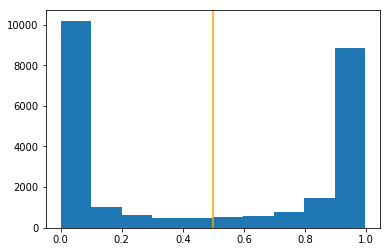

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.46'